In [1]:
import tensorflow as tf
from keras.layers import Input, Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D, concatenate, Activation
from keras.applications.mobilenet import MobileNet as Net

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.layers import Input, merge
from keras.optimizers import Adam
import cv2
import numpy as np
import os
from tqdm import tqdm
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

ALPHA = 0.3  # Triplet Loss Parameter

from keras.layers import Input,Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D,concatenate,Activation
from keras.applications.xception import Xception as Net
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.models import Model

/Users/s0c02nj/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
import matplotlib.pyplot as plt

In [ ]:
#x_train.shape

In [7]:
def triplet_loss(x):
    anchor, positive, negative = x
    
    #x = tf.constant([[1, 1, 1], [1, 1, 1]]) ------ tf.reduce_sum(x, 1)  # [3, 3]
    #It is trained in batches so, the tensor will be of the above shape for each triplet
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
    
    #x = tf.constant([[1, 1, 1], [1, 1, 1]])--------->tf.reduce_sum(x, 0)  # [2, 2, 2]

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss


In [8]:
x = tf.constant([[1, 3, 1], [3, 1, 1]]) 
y = tf.constant([[2, 1, 1], [1, 2, 1]]) 
z=  tf.constant([[2, 1, 1], [2, 2, 1]]) 


z1=tf.reduce_sum(tf.square(tf.subtract(x, y)), 1)
z2=tf.reduce_sum(tf.square(tf.subtract(x, z)), 1)

sess=tf.Session()
print sess.run([z1,z2])
sess.close()
#tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)

[array([5, 5], dtype=int32), array([5, 2], dtype=int32)]


In [9]:
def make_model(input_shape):
    
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    
    return cnn_model
    

In [16]:
def create_model(d1, d2, c):
    
    # The triplet network takes 3 input images: 2 of the same class and 1 out-of-class sample
    #shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) 
    #indicates that the expected input will be batches of 32-dimensional vectors.
    
    anchor_example =   Input(shape=(d1, d2, c), name = 'anchor')
    positive_example = Input(shape=(d1, d2, c), name = 'positive')
    negative_example = Input(shape=(d1, d2, c), name = 'negative')
        
    base_model = Net(input_shape=(d1,d2,3),weights='imagenet',include_top=False)
    # the weights of this layer will be set to ones and fixed  (since they
    # are shared we could also leave them trainable to get a weighted sum)
    
    # feed all 3 inputs into the pretrained keras model
    x1 = base_model(anchor_example)
    x2 = base_model(positive_example)
    x3 = base_model(negative_example)
    
    # flatten/summarize the models output:
    # (here we could also use GlobalAveragePooling or simply Flatten everything)
    #Takes the max value for each of the filter
    anchor =   GlobalMaxPooling2D()(x1)
    positive = GlobalMaxPooling2D()(x2)
    negative = GlobalMaxPooling2D()(x3)
    
    
    #Loss gives the final loss value between a,p and n.
    loss = merge([anchor, positive, negative], mode=triplet_loss, output_shape=(1,))

    
    triplet_model = Model(inputs=[anchor_example, positive_example, negative_example],
                  outputs=loss)
    
    triplet_model.compile(loss='mean_absolute_error', optimizer=Adam())
    print(triplet_model.summary())
    
    return triplet_model

In [17]:
triplet_model=create_model(128, 128, 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 4, 4, 2048)   20861480    anchor[0][0]                     
                                                                 positive[0][0]                   
          

/Users/s0c02nj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


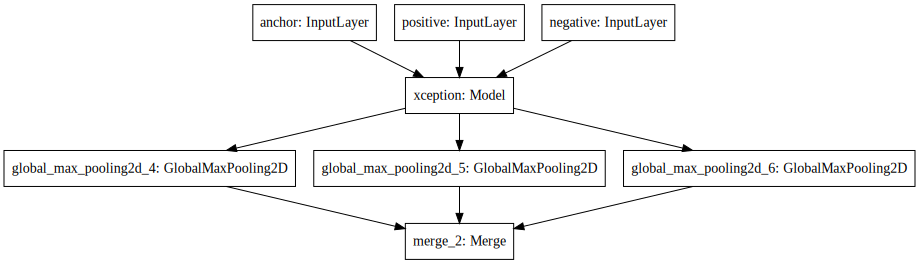

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(triplet_model).create(prog='dot', format='svg'))

In [15]:
#!rm 'images/.DS_Store'

In [ ]:
'''def load_images(path):
    
    dataset=[]
    #List all the files in a directory
    labels = os.listdir(path)
    
    for label in tqdm(labels):
        
        #Making list for separate classes
        images = os.listdir(path+"/"+label)
        
        for image in list(filter(lambda a: '.DS_Store' != a, images)):
            anchor = cv2.imread(path+"/"+label+"/"+image)
            for image1 in list(filter(lambda a: '.DS_Store' != a, images)):
                p_img = cv2.imread(path+"/"+label+"/"+image1)
                labels1 = [i for i in labels if i!=label]
                
                for label1 in labels1:
                    images2 = os.listdir(path+"/"+label1)
                    for image2 in list(filter(lambda a: '.DS_Store' != a, images2)):
                        n_img = cv2.imread(path+"/"+label1+"/"+image2)
                        dataset.append((anchor, p_img, n_img))
    return dataset '''

In [ ]:
def generator():
    dataset=load_images("images")

    anchor=[]
    p_img=[]
    n_img=[]
    
    for i,j,k in dataset:
        anchor.append(i)
        p_img.append(j)
        n_img.append(k)
    
    anchor=np.array(anchor)
    p_img=np.array(p_img)
    n_img=np.array(n_img)
    
    return anchor, p_img, n_img

In [ ]:
anchor, p_img, n_img = generator()

In [ ]:
print(anchor.shape)

In [ ]:
model.fit(x=[anchor, p_img, n_img], y=np.zeros(anchor.shape[0]), verbose=1, batch_size=2048, epochs=2) 

In [ ]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('global_max_pooling2d_4').output)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
for i in range(21, 40):
    
    f, axarr = plt.subplots(2,2)
    
    intermediate_output_a = intermediate_layer_model.predict([anchor[i-1:i], p_img[i-1:i], n_img[i-1:i]])
    intermediate_output_b = intermediate_layer_model.predict([n_img[i-1:i], p_img[i-1:i], n_img[i-1:i]])
    
    axarr[0,0].imshow(anchor[i])
    axarr[0,1].imshow(n_img[i])
    
    plt.show()
    print "distance between above two images", np.linalg.norm(intermediate_output_a[0]-intermediate_output_b[0])
    
    



In [24]:
#import keras
tf.__version__

'1.4.1'

In [12]:
x=[1,2,3,4,5,12,3,3,4,4,4,4,45,5,5,5,5,5,5,5]
type(x)

list

(array([18.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <a list of 10 Patch objects>)

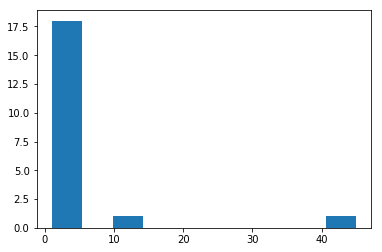

In [13]:
plt.hist(x)